In [1]:
import logging
import warnings

level = logging.CRITICAL
logger = logging.getLogger()
logger.setLevel(level)
for handler in logger.handlers:
    handler.setLevel(level)
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ["PATH"] = os.pathsep + os.path.join("..", "mlp_solver")

In [3]:
!ipopt -v

Ipopt 3.12.13 (Linux x86_64), ASL(20211109)



In [4]:
%%capture --no-stdout
from dsl import spec, SpecTracker
from dsl.grammar import (
    create_variable as V,
    Expectation as E,
    RETURN_VARIABLE as r,
    Specification
)
import matplotlib.pyplot as plt
import numpy as np
from typing import ClassVar
#from tqdm.notebook import tqdm
from tqdm import tqdm

In [5]:
%%capture --no-stdout
#%matplotlib widget
%matplotlib inline
from dsl.tests.datasets import get_dataset_names, get_dataset_attr_list, get_dataset_attr_dict, Dataset, get_dataset
from dsl.tests.models import get_models, get_model, ModelBasedTest, InvalidTargetError, InvalidTrainError, _view_maintenance

In [6]:
class CustomDatasetModel(ModelBasedTest):
    def __init__(self, dataset, output_var, input_vars, model: ClassVar[ModelBasedTest]):
        self.output_var = output_var
        self.input_vars = input_vars
        attrs = dataset.attributes_dict
        self.dataset: Dataset = Dataset(dataset.train, dataset.test, attrs, target=output_var, inputs=input_vars)
        self.model = model(self.dataset)
        self.output_col = None

    def update_spec(self, new_spec):
        if not isinstance(new_spec, Specification):
            raise ValueError("Input provided was not parsed into a specification")
        @spec(new_spec)
        def decision_func(**kwargs):
            x = kwargs.get("x")
            # prediction = self.model.model.predict(x.reshape(1, -1)) # TODO??
            prediction = self.model.predict(x.reshape(1, -1))
            return prediction[0]
        self.f_x = decision_func

    @property
    def data(self):
        test_data = []
        for _, d in self.dataset.test.iterrows():
            x = d.loc[self.input_vars].to_numpy()
            data_dict = {
                "x": x
            }
            for ind, attr in enumerate(self.dataset.attributes_dict.keys()):
                data_dict[attr] = d[attr]
            test_data.append(data_dict)
        return test_data

    def pred_list(self, input_list):
        preds = self.model.predict_list(input_list)
        return preds
    
    
    def eval_using_output_col(self, new_spec, output_col, progress_bar=None, our_approach=True):
        @spec(new_spec, include_confidence=True, delta=0.1, our_approach=our_approach)
        def decision_function(**kwargs):
            return kwargs.get(output_col)
            
        
        self.f_x = decision_function
        
        initial_test_data = self.data
        for (ind, row), d in zip(self.dataset.test.iterrows(), initial_test_data):
            d[output_col] = row.loc[output_col]
            
        iteration_data = initial_test_data
        if progress_bar:
            iteration_data = progress_bar(iteration_data)
        for datum in iteration_data:
            r, history = self.f_x(**datum)
        return initial_test_data, history

In [7]:
datasets = get_dataset_names()
datasets

['Boston Housing Prices', 'Adult Income', 'Rate My Professors', 'Compas']

In [8]:
dataset_name = "Rate My Professors"
dataset = get_dataset(dataset_name)
dataset_attr_dict = get_dataset_attr_dict(dataset_name)
print(f"Loaded {dataset_name}")

Loaded Rate My Professors


In [9]:
models = get_models()
models

['Linear Regression',
 'Decision Tree',
 'Logistic Regression',
 'RBF-SVM Classification',
 'Three Layer MLP',
 'Bert Text Regression',
 'View Maintenance']

In [10]:
base_model = get_model("Bert Text Regression")

In [11]:
output_var = dataset.target
dataset.attributes
input_vars = ["comments"]

In [12]:
len(dataset.train_Xy[0])

16000

In [13]:
model = CustomDatasetModel(dataset, output_var, input_vars, base_model)

## Set column using list pred

In [14]:
outputs = model.pred_list(model.dataset.test[input_vars[0]].tolist())

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
model.dataset.test["pred"] = outputs

## Our method

In [16]:
my_spec = (E(r > 3, given=((V("gender") == "female"))) / E(r > 3, given=((V("gender") == "male"))) < 1.2) & \
(E(r > 3, given=((V("gender") == "male"))) / E(r > 3, given=((V("gender") == "female"))) > 0.8)

In [17]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# disable HF warnings

In [18]:
%%capture --no-display
test_data = model.eval_using_output_col(my_spec, "pred", progress_bar=tqdm)

In [19]:
def get_plot_and_vals(val_to_track, hline_t):
    xs, ys, cs, deltas = [], [], [], []
    #val_to_track = str(my_spec.left_child.left_child.expectation_term)
    for x, hist_val in model.f_x.spec_val_history:
        xs.append(x)
        val = hist_val[val_to_track]
        ys.append(val.val)
        cs.append(val.epsilon)
        deltas.append(val.delta)

    xs, ys, cs = (np.array(t) for t in (xs, ys, cs))
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(xs, ys, color="b")
    ax.plot(xs, ys+cs, color="r", linestyle="dashed")
    ax.plot(xs, ys-cs, color="r", linestyle="dashed")
    ax.hlines(y=hline_t, xmin=np.min(xs), xmax=np.max(xs))
    ax.fill_between(xs, ys-cs, ys+cs, color="b", alpha=.1)
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.set_ylim((-1, 1))
    return fig, ax, xs, ys, cs, deltas

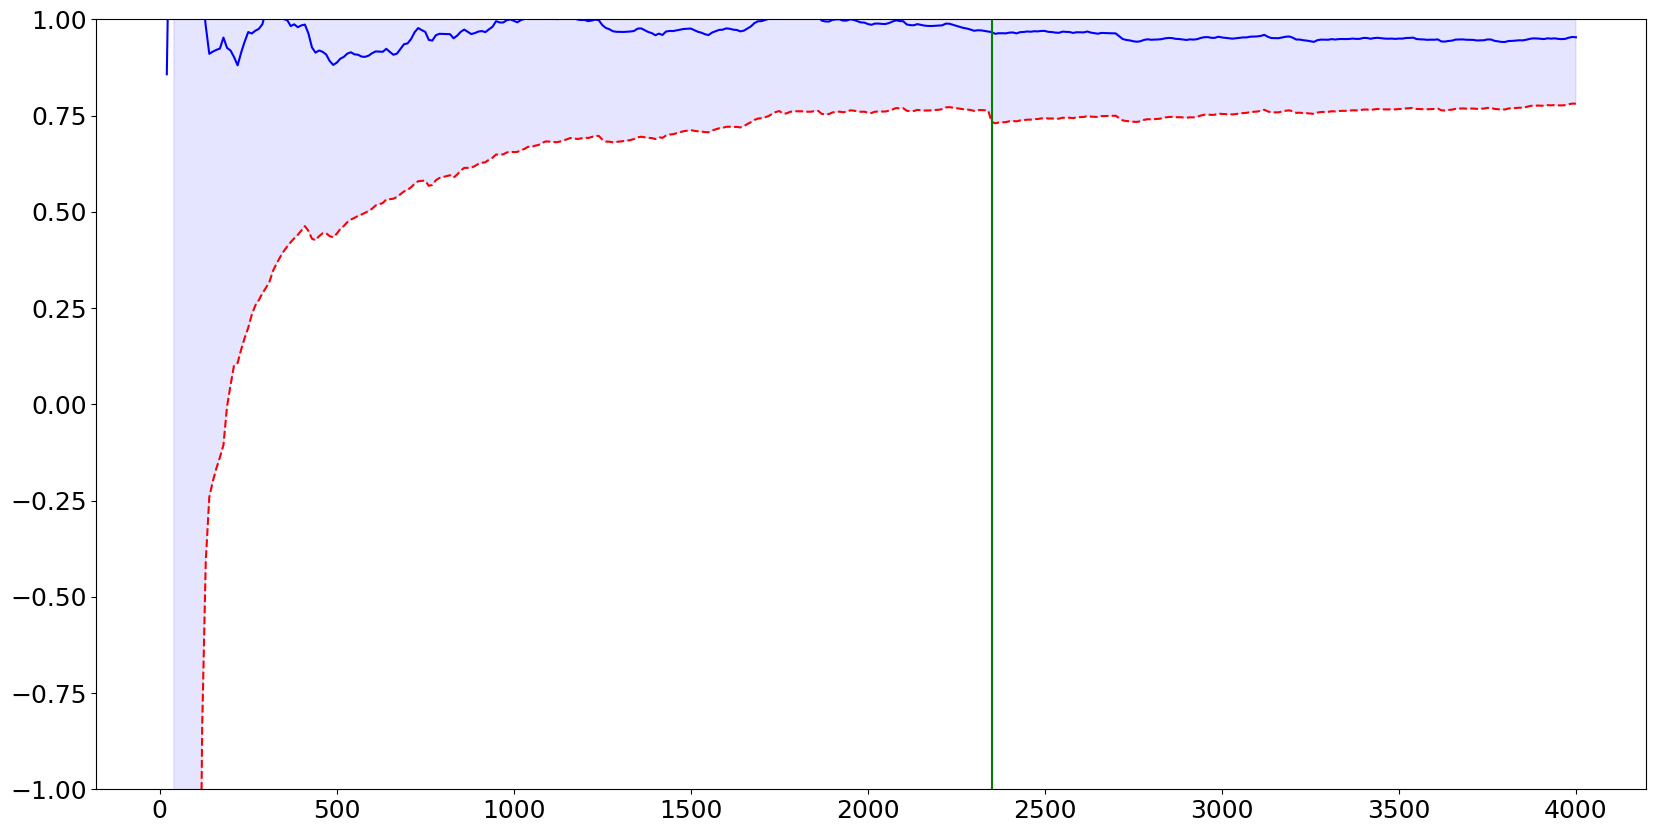

In [20]:
fig, ax, xs, ys, cs, deltas = get_plot_and_vals(my_spec.left_child.left_child.expectation_term.row_id, my_spec.left_child.left_child.threshold.val)
opt_step = model.f_x.optimization_achieved_step
ax.vlines(opt_step, ymin=-2, ymax=2, color="g")

In [21]:
#fig, ax, xs, ys, cs, deltas = get_plot_and_vals(my_spec.right_child.left_child.expectation_term.row_id, my_spec.right_child.left_child.threshold.val)
#opt_step = model.f_x.optimization_achieved_step
#ax.vlines(opt_step, ymin=-2, ymax=2, color="g")


In [22]:
our_model_opt_step = model.f_x.optimization_achieved_step
our_model_opt_step

2350

## Running with Verifair

In [23]:
my_spec_o = (E(r > 3, given=((V("gender") == "female"))) / E(r > 3, given=((V("gender") == "male"))) < 1.2) & \
(E(r > 3, given=((V("gender") == "male"))) / E(r > 3, given=((V("gender") == "female"))) > 0.8)

In [24]:
test_data = model.eval_using_output_col(my_spec_o, "pred", progress_bar=tqdm, our_approach=False)

100%|█████████████████████████████████████████████████████████████████████████| 4000/4000 [00:15<00:00, 251.70it/s]


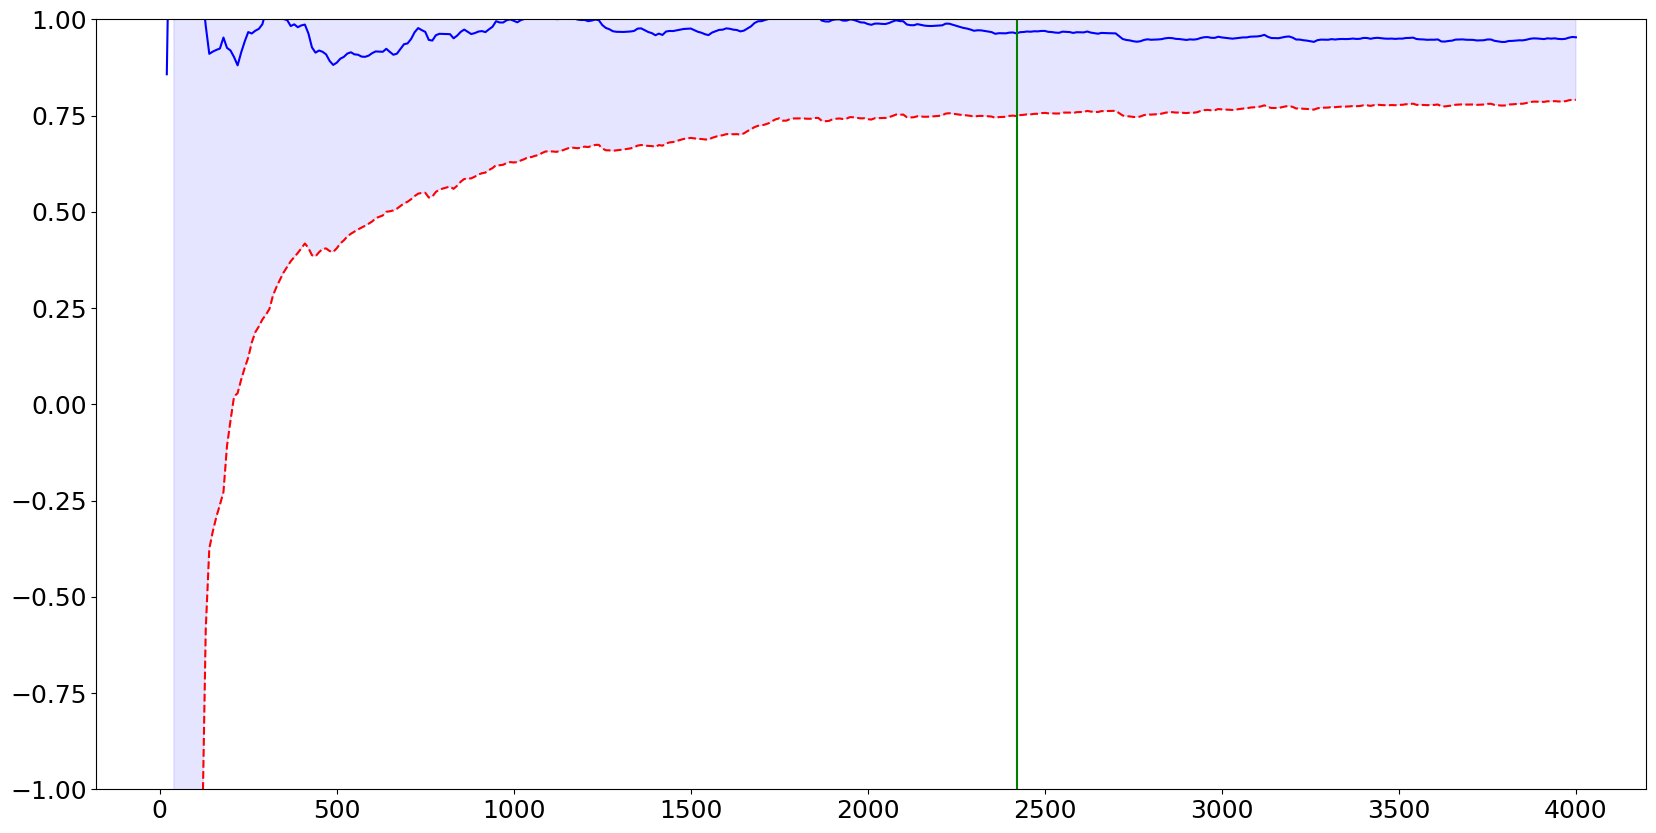

In [25]:
fig_o, ax_o, xs_o, ys_o, cs_o, deltas_o = get_plot_and_vals(my_spec_o.left_child.left_child.expectation_term.row_id, my_spec.left_child.left_child.threshold.val)
opt_step_o = model.f_x.optimization_achieved_step
ax_o.vlines(opt_step_o, ymin=-2, ymax=2, color="g")

In [26]:
#fig, ax, xs, ys, cs, deltas = get_plot_and_vals(my_spec_o.right_child.left_child.expectation_term.row_id, my_spec_o.right_child.left_child.threshold.val)
#opt_step_o = model.f_x.optimization_achieved_step
#ax.vlines(opt_step_o, ymin=-2, ymax=2, color="g")

In [27]:
verifair_opt_step = model.f_x.optimization_achieved_step
verifair_opt_step

2420

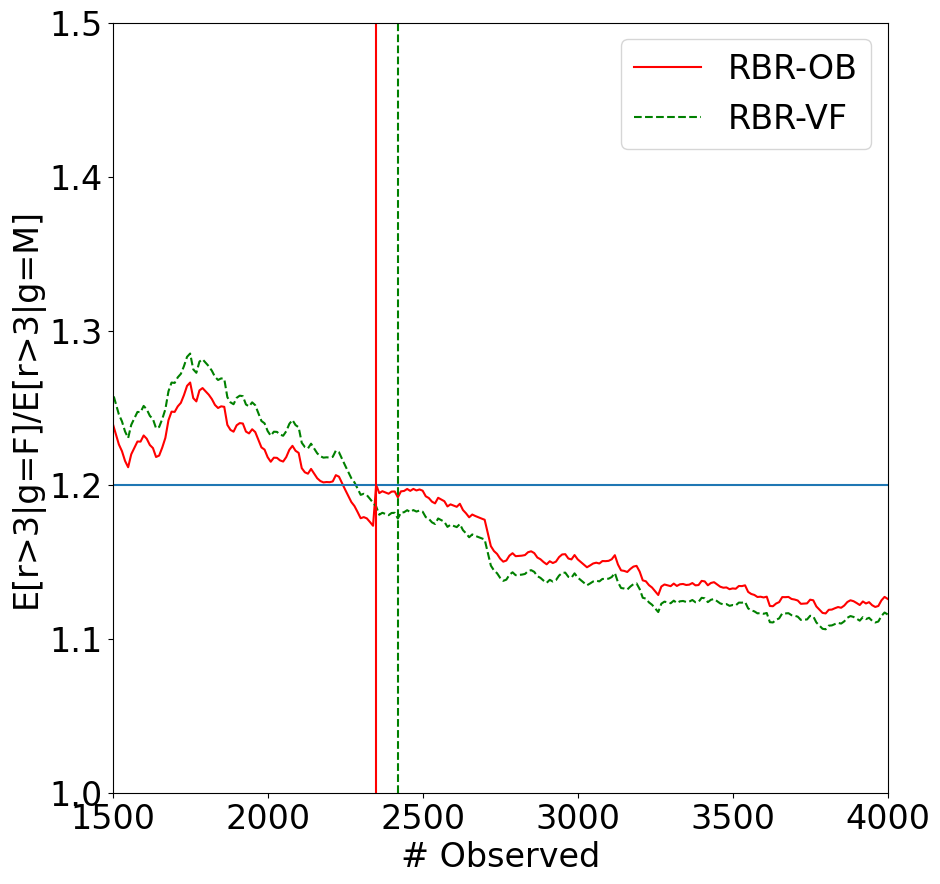

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
# first add ours
ax.plot(xs, ys + cs, color="r", label="RBR-OB")
ax.plot(xs_o, ys_o + cs_o, color="g", linestyle="dashed", label="RBR-VF")
ax.hlines(1.2, xmin=np.min(xs_o), xmax=np.max(xs_o))
ax.set_ylim(1, 1.5)
ax.vlines(our_model_opt_step, ymin=1, ymax=1.5, color="r")
ax.vlines(verifair_opt_step, ymin=1, ymax=1.5, color="g", linestyle="dashed")
#ax.set_xlim(2200, 2300)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_ylabel("E[r>3|g=F]/E[r>3|g=M]", fontsize=24)
ax.set_xlabel("# Observed", fontsize=24)
ax.set_xlim(1500, 4000)
ax.legend(fontsize=24)

In [33]:
fig.savefig("plots/ratemyprofs.png")